In [1]:
import gym
import stable_baselines3
from stable_baselines3 import PPO, DDPG, A2C

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray

import random
import math
from functools import partial
from scipy.stats import gamma

import json
import os
import sys
import time

import fair
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year

/Users/samart/opt/anaconda3/envs/MLforEE/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fair.__version__

'2.1.0'

In [3]:
scenario = 'ssp245' #scenario to use as baseline

# Load Data

In [4]:
data_path = '../data/example_github_data/'
volcano_df = pd.read_csv(os.path.join(data_path, 'volcano_forcing_data.csv'), index_col='year').drop(['Unnamed: 0'], axis=1)
print(volcano_df.head())

climate_df = pd.read_csv(os.path.join(data_path, 'climate_models_data.csv')).drop(['Unnamed: 0'], axis=1)
climate_df.head(2)

                  erf
year                 
1750.000000  0.246406
1750.083333  0.246408
1750.166667  0.246409
1750.250000  0.246410
1750.333333  0.246411


,model,run,conv,nit,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
0,CAMS-CSM1-0,r1i1p1f1,True,4809,28.239872,2.632439,9.262195,52.927697,1.876254,5.153591,0.643546,1.285458,2.690512,0.439493,8.870602
1,GISS-E2-2-G,r1i1p1f1,True,3965,2.385368,3.601142,11.333337,313.520678,1.972359,1.922481,0.631276,0.443575,0.544189,0.535407,8.035197


In [5]:
def ssp(scenario, category='emissions'):
    assert (category=='emissions' or category=='concentrations')
    path = '../data/fair_ssp_scenarios/' + scenario + "_" + category + ".csv"
    ssp = pd.read_csv(path).drop(['Unnamed: 0'], axis=1)
    ssp['Year'] = ssp['Year'].astype(np.int16)
    return(ssp)

In [6]:
def xequals(d1, d2):
    assert type(d1) == type(d2), "Type mismatch"
    if(type(d1) == xarray.core.dataset.Dataset):
        a = np.nan_to_num(d1.to_array())
        b = np.nan_to_num(d2.to_array())
    elif(type(d1) == xarray.core.dataarray.DataArray):
        a = np.nan_to_num(d1.data)
        b = np.nan_to_num(d2.data)
    res = np.array_equal(a, b)
    if not res:
        return(res, np.where(a!=b, 1, 0))
    return(res)

def models_equal(f1, f2):
    
    #equal if all attributes same values
    
    if(xequals(f1.species_configs, f2.species_configs) and xequals(f1.climate_configs, f2.climate_configs)):
        if(xequals(f1.stochastic_forcing, f2.stochastic_forcing) and xequals(f1.emissions, f2.emissions) and xequals(f1.forcing_sum, f2.forcing_sum)):
            if(xequals(f1.concentration, f2.concentration) and xequals(f1.forcing, f2.forcing) and xequals(f1.temperature, f2.temperature)):
                if(xequals(f2.airborne_emissions, f1.airborne_emissions) and xequals(f2.ocean_heat_content_change, f1.ocean_heat_content_change)):
                    return(xequals(f2.toa_imbalance, f1.toa_imbalance) and xequals(f2.cumulative_emissions, f1.cumulative_emissions))
                else:
                    print('d')
            else:
                print('c')
        else:
            print('b')
    else:
        print('a')
    return(False)

# Reward Functions

In [7]:

#state is [cur_temp, emit_c, emit_s, conc_c, forcing]

def simple_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # positive reward for temp decrease
    # negative cliff if warming exceeds 2º
    cur_temp = state[0]
    if cur_temp > 2:
        return -100
    return (old_state[0] - cur_temp) # punish 

def simple_temp_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # positive reward for temp under 1.5 goal
    cur_temp = state[0]
    if cur_temp > 3.5:
        return -100
    return 100*(1.5 - cur_temp)

def conc_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # positive reward for decreased concentration
    cur_temp = state[0]
    if cur_temp > 2:
        return -100
    return old_state[3] - state[3] # punish for increase in co2 concentration

def carbon_cost_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # impose a cost for each GtC emitted
    cur_temp, cur_emit = state[0], state[1]
    if cur_temp > 2:
        return -100
    return -cur_emit

#state is [cur_temp, emit_c, emit_s, conc_c, forcing]

def carbon_cost_GDP_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    cur_temp = state[0]
    reward = 100 * cur_fease
    alpha = 1000 if cur_temp > 2 else 200
    reward += alpha * (2-cur_temp)  
    reward += GDP/1e12
    reward -= GDP_cost/1e11
    
    if(abs(reward) > 7000):
        print("Noteworthy reward: ", reward)
        print([old_state, state, year, GDP, GDP_cost, cur_fease]) 
        print()
        
    return reward

def temp_emit_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # positive reward for keeping the temp under 1.5
    # negative reward for amount of emissions reduction
    # positive cliff for success at the end of the trial
    # w could indicate cost
    
    cur_temp, cur_emit_c = state[0], state[1]
    if cur_temp > 2:
        return -100
    if year==2100 and temp<=1.5:
        return 1000
    temp = 10*(old_state[0] - cur_temp)
    emit_decrease = old_state[1] - cur_emit_c # decrease in emissions
    if emit_decrease>0:
        return temp + emit_decrease
    return temp


def temp_emit_diff_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # positive reward for keeping the temp under 1.5
    # negative reward for amount of emissions reduction
    # (reduction compared to projected amount for that year)
    # positive cliff for success at the end of the trial
    # w could indicate cost of emissions
    cur_temp, cur_emit = state[0], state[1]
    if cur_temp > 2:
        return -100
    if year==2100 and cur_temp <=1.5:
        return 100
    curval = (year-2021)*0.6 + 36
    temp_decrease = 10*(old_state[0] - cur_temp) #magnified decrease in temp
    emit = curval - cur_emit
    if emit>0:
        return temp_decrease + emit
    return temp_decrease

# Setup Environment and Econ Model

In [8]:
scenario = 'ssp245' #scenario to use as baseline

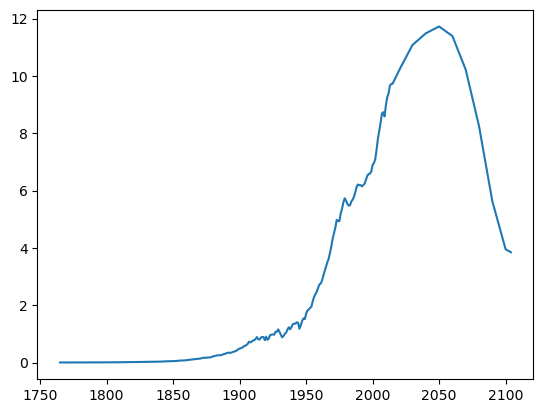

,Year,CO2-fossil (GtC/yr),CO2-landuse (GtC/yr),CH4 (Mt/yr),N2O (MtN2/yr),SOx (MtS/yr),CO (Mt/yr),NMVOC (Mt/yr),NOx (MtN/yr),BC (Mt/yr),...,Methyl chloroform (kt/yr),HCFC22 (kt/yr),HCFC141b (kt/yr),HCFC142b (kt/yr),Halon 1211 (kt/yr),Halon 1202 (kt/yr),Halon 1301 (kt/yr),Halon 2401 (kt/yr),CH3Br (kt/yr),CH3Cl (kt/yr)
0,1765,0.003046,0.106705,20.919155,0.113903,1.250025,352.932726,60.629458,3.878199,2.123600,...,0.0,0.0,0.0,0.0,0.007723,0.0,0.0,0.0,105.07293,4274.9668
1,1766,0.003396,0.108668,20.853592,0.116055,1.243445,349.380645,59.858785,3.884896,2.110460,...,0.0,0.0,0.0,0.0,0.007723,0.0,0.0,0.0,105.07758,4275.2111
2,1767,0.003397,0.110667,20.999179,0.118247,1.242612,349.616099,59.891027,3.880520,2.112461,...,0.0,0.0,0.0,0.0,0.007723,0.0,0.0,0.0,105.08566,4275.6359
3,1768,0.003398,0.112703,21.659452,0.120481,1.293980,362.653685,62.365826,4.039050,2.183132,...,0.0,0.0,0.0,0.0,0.007723,0.0,0.0,0.0,105.04673,4273.5893
4,1769,0.003400,0.114777,21.496335,0.122758,1.272649,355.025419,60.950404,3.914664,2.137634,...,0.0,0.0,0.0,0.0,0.007723,0.0,0.0,0.0,105.07670,4275.1650


In [9]:
ssp_df = ssp(scenario)
plt.plot(ssp_df[ssp_df['Year'] < 2105]['Year'], ssp_df[ssp_df['Year'] < 2105]['CO2-fossil (GtC/yr)'])
plt.show()
ssp_df.head()

In [10]:
current_year = 2023
end_year = 2100

size = ssp_df.shape[0]
print(size)

736


In [11]:
# Economic parameters
beta = 1.03 # estimated GDP growth rate over the year
epsilon = 147.0 # USD/GJ
rho = 2.0 # 1
sigma = 4e12 # GJ
tau_S = 65.0 # yr

# cost to lower emissions by 1 GtC
GtC_reduce_cost = 6e11


In [12]:
# cost model for SAI
cost_per_MT = 1000 * 1e6 # cost per ton * 10^6 tons / Mt
airplane_construction_cost = 1e8 # construction of additional airplane
cost_per_year_deployed = 12 * 8e5 # annual lease rate = 12 * monthly

payload_per_year_tons = 20 * 5  * 330 # tons/run * runs / day * operating days/year
annual_delivery_capacity = payload_per_year_tons / 1e6 # how much sulfur a single plane can emit in a year
annual_delivery_capacity

0.033

In [13]:
# setup economic variables to be updated throughout run

Y = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #global GDP
Y_cost = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #cost of climate change
S = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #renewable knowledge stock

S.loc[:current_year-1] = 5e11 #GJ
Y.loc[:current_year-1] = 9e13 #USD/a
Y_cost.loc[:current_year-1] = 100*1e9 #USD/a

S[current_year] = 5e11 #GJ
Y[current_year] = 9.2e13 #USD/a
Y_cost[current_year] = 100*1e9 #USD/a

In [14]:
# basic model
species, properties = read_properties()
averages = climate_df.drop_duplicates(subset=['model'], keep='first').mean(numeric_only=True)

def setup_model(end_year=2105, scenario='ssp245', timesteps_per_year=1):
    
    # consider fiddling with sulfur properties since forcing seems weak and f.forcing does not include sulfur
    
    f = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    f.define_time(1750, end_year, 1/timesteps_per_year) #timepoints, timebounds
    f.define_scenarios([scenario])
    f.define_configs(['default', 'intervention'])
    f.define_species(species, properties)
    f.timesteps_per_year = timesteps_per_year
    f.allocate()

    # fill species configs using default values
    f.fill_species_configs()
    fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

    # Use climate_df for climate configs. take the average of the first runs of all models to obtain climate params
    fill(f.climate_configs['ocean_heat_capacity'], averages.loc['C1':'C3'].values)
    fill(f.climate_configs['ocean_heat_transfer'], averages.loc['kappa1':'kappa3'].values)
    fill(f.climate_configs['deep_ocean_efficacy'], averages['epsilon'])
    fill(f.climate_configs['gamma_autocorrelation'], averages['gamma'])
    fill(f.climate_configs['sigma_eta'], averages['sigma_eta'])
    fill(f.climate_configs['sigma_xi'], averages['sigma_xi'])
    fill(f.climate_configs['stochastic_run'], True)
    fill(f.climate_configs['use_seed'], True)
    fill(f.climate_configs['seed'], 1355763)

    f.fill_from_rcmip()

    volcanic_forcing = np.zeros(f.timebounds.size)
    volcanic_forcing[:timesteps_per_year*270] = volcano_df.iloc[::int(12/timesteps_per_year)].squeeze().values
    fill(f.forcing, volcanic_forcing[:, None, None], specie='Volcanic')

    initialise(f.concentration, f.species_configs['baseline_concentration'])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    
    return(f)

In [15]:
scenario = "ssp245"
ref_model = setup_model(2105, scenario, 1)

species_configs_ref = ref_model.species_configs.copy(deep=True)
climate_configs_ref = ref_model.climate_configs.copy(deep=True)
emissions_ref = ref_model.emissions.copy(deep=True)
concentration_ref = ref_model.concentration.copy(deep=True)
forcing_ref = ref_model.forcing.copy(deep=True)
forcing_sum_ref = ref_model.forcing_sum.copy(deep=True)
temperature_ref = ref_model.temperature.copy(deep=True)
cumulative_emissions_ref = ref_model.cumulative_emissions.copy(deep=True)
airborne_emissions_ref = ref_model.airborne_emissions.copy(deep=True)
airborne_fraction_ref = ref_model.airborne_fraction.copy(deep=True)
ocean_heat_content_change_ref = ref_model.ocean_heat_content_change.copy(deep=True)
stochastic_forcing_ref = ref_model.stochastic_forcing.copy(deep=True)
toa_imbalance_ref = ref_model.toa_imbalance.copy(deep=True)

def model_reset_2(end_year=2105, timesteps_per_year=1): # faster than setup_model() because that function is too slow in practice
    g = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    g.define_time(1750, end_year, 1) #timepoints, timebounds
    g.define_scenarios([scenario])
    g.define_configs(['default', 'intervention'])
    g.define_species(species, properties)
    g.allocate()
    
    g.timesteps_per_year = timesteps_per_year
    g.species_configs = species_configs_ref
    g.climate_configs = climate_configs_ref
    g.emissions = emissions_ref
    g.concentration = concentration_ref
    g.forcing = forcing_ref
    g.forcing_sum = forcing_sum_ref
    g.temperature = temperature_ref
    g.cumulative_emissions = cumulative_emissions_ref
    g.airborne_emissions = airborne_emissions_ref
    g.airborne_fraction = airborne_fraction_ref
    g.ocean_heat_content_change = ocean_heat_content_change_ref
    g.stochastic_forcing = stochastic_forcing_ref
    g.toa_imbalance = toa_imbalance_ref
    
    return(g)

def model_reset(end_year=2105, timesteps_per_year=1): # faster than setup_model() because that function is too slow in practice
    g = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    g.define_time(1750, end_year, 1) #timepoints, timebounds
    g.define_scenarios([scenario])
    g.define_configs(['default', 'intervention'])
    g.define_species(species, properties)
    g.allocate()
    
    g.timesteps_per_year = timesteps_per_year
    g.species_configs = ref_model.species_configs.copy(deep=True)
    g.climate_configs = ref_model.climate_configs.copy(deep=True)
    g.emissions = ref_model.emissions.copy(deep=True)
    g.concentration = ref_model.concentration.copy(deep=True)
    g.forcing = ref_model.forcing.copy(deep=True)
    g.forcing_sum = ref_model.forcing_sum.copy(deep=True)
    g.temperature = ref_model.temperature.copy(deep=True)
    g.cumulative_emissions = ref_model.cumulative_emissions.copy(deep=True)
    g.airborne_emissions = ref_model.airborne_emissions.copy(deep=True)
    g.airborne_fraction = ref_model.airborne_fraction.copy(deep=True)
    g.ocean_heat_content_change = ref_model.ocean_heat_content_change.copy(deep=True)
    g.stochastic_forcing = ref_model.stochastic_forcing.copy(deep=True)
    g.toa_imbalance = ref_model.toa_imbalance.copy(deep=True)
    
    return(g)

In [16]:
# timing how long a reset takes using preloaded reference method

tot = 0
for i in range(100):
    s = time.time()
    a = model_reset()
    tot += time.time() - s
tot*10, "ms"

(11.913731098175049, 'ms')

In [17]:
# timing how long a manual reset takes
s = time.time()
ref_model = setup_model(2105, scenario, 1)
time.time() - s, 's'

(2.091062068939209, 's')

# Creating Reinforcement Learning Environment using gym Class

In [55]:

class Simulator(gym.Env):
    
    def __init__(self, reward_mode=temp_emit_diff_reward, max_carbon=32, max_aerosol=100, clim_model=model_reset(),
                current_year=2023, end_year=2104, scenario=scenario):
        
        # action space for the environment,
        # the amount to increase or decrease emissions by
        self.action_space = gym.spaces.Box(
            low = np.array([-max_carbon, 0]).astype(np.float32),
            high = np.array([max_carbon, max_aerosol]).astype(np.float32),
        )
        
        self.model = clim_model 
        
        # state space, [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
        self.observation_space = gym.spaces.Box(
            low=np.array([-4, -200, -100, 0, -20.0]).astype(np.float32),
            high=np.array([5, 200, 1000, 5000, 20.0]).astype(np.float32),
        )
        
        self.reward_func = eval(reward_mode) if type(reward_mode)==str else reward_mode # specify the reward function to use
        #self.scenario = scenario # not used currently; default rcmip data regardless
        #self.scenario_emissions = ssp(scenario) # not used currently; default rcmip data regardless
        self.state = None
        
        #for feasibility testing later
        self.ssp_370 = ssp('ssp370')        
        
        # setup time bounding
        self.start_year = current_year
        self.end_year = end_year
        self.time_increment = self.model.timesteps_per_year # gonna be 1
        
        # used for aerosol cost
        self.airplanes_manufactured = 0
    
        
    def reset(self):
        
        ## RESET ECONOMIC VARIABLES
        
        Y = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #global GDP
        Y_cost = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #cost of climate change
        S = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #renewable knowledge stock

        S.loc[:current_year-1] = 5e11 #GJ
        Y.loc[:current_year-1] = 9e13 #USD/a
        Y_cost.loc[:current_year-1] = 100*1e9 #USD/a

        S[current_year] = 5e11 #GJ
        Y[current_year] = 9.2e13 #USD/a
        Y_cost[current_year] = 100*1e9 #USD/a
        
        ##             ##
        
        
        ## reset- faster than calling setup_model() again
        self.model = model_reset()
        self.t = self.start_year - 1
        
        self.update_state(ref_model.emissions)
        
        return(self.state[self.model.configs[1]])                           
    
    
    def update_state(self, emissions):
        
        self.forward_func(emissions)   
        # state is [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]   
        # state refers to at the conclusion of year X, all variables. At end, we are at beginning of year X+1
        self.state = {
            'Year' : self.t,
            self.model.configs[0] : np.array([
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[0], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[0], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[0]].item()                
            ], dtype=np.float32),
            self.model.configs[1] : np.array([ 
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[1], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[1], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[1]].item()
            ], dtype=np.float32)
        }
                               
        self.t += self.time_increment
    
    def access_state(self):
        return(self.state)
    
    def forward_func(self, emissions):

        self.model = model_reset()
        self.model.emissions = emissions.copy(deep=True)
        
        self.model.run(progress=False)
    
    def aerosol_cost(self, emit):
        
        # 3 factors: operating cost, construction cost, sulfur cost
        num_airplanes = emit / annual_delivery_capacity # how many airplaces deployed
        operational_cost = num_airplanes * cost_per_year_deployed
        
        num_new_airplaces = num_airplanes - self.airplanes_manufactured # number of new planes needed to service additional emissions
        construction_cost = max(num_new_airplaces, 0) * airplane_construction_cost # cost of constructing new plances
        
        sulfur_cost = emit * cost_per_MT
        
        self.airplanes_manufactured = max(int(num_airplanes), int(self.airplanes_manufactured))
        
        return(sulfur_cost + construction_cost + operational_cost)
        
    
    def render(self, mode="human"):
        if(self.state):
            print(f"Current Year: {self.state['Year']}")
            print("Without intervention:")
            config = self.model.configs[0]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
            
            print("\nWith intervention:")
            config = self.model.configs[1]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
        else:
            print("No state initialized; call reset. ")
    
    
    def step(self, action):
        
        #should not call step without calling reset()
        if(not self.state): #has not been initialized
            self.reset()
    
        config = self.model.configs[1] #intervention
        old_state = self.state[config] #save for reward function
        year = self.t
        done = False
        
        
        # change emissions by action[0] from the previous year
        # emit action amount additional sulfur within same year
        new_emissions = self.model.emissions
        emit_C = max(new_emissions.loc[self.t-0.5, self.model.scenarios[0], config, 'CO2 FFI'].item() + action[0], 0)
        emit_S = new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] + action[1]
        
        new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'CO2 FFI'] = emit_C
        new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] = emit_S
        
        
        # run model simulation with new values
        #state is [year, temp, emit_c, emit_s, conc_c, forcing]
        self.update_state(new_emissions) #CAUTION! self.t has now changed
        
        #Implementation of S, Y and Y_cost
        Y[year] = beta * Y[year-1] # assume constant GDP growth of beta percent
        
        emission_cost = GtC_reduce_cost * (old_state[1] - self.state[config][1])
        Y_cost[year] = (10/5 * self.state[config][0] - 2)/100 * Y[year] + self.aerosol_cost(action[1]) + emission_cost
        
        # gamma = 1 / ( 1+(S[year-1]/sigma)**rho )
        #S[year] = S[year-1] + ( (1-gamma)*Y[year-1]/epsilon - S[year-1]/tau_S ) # not used in this implementation
        
        # fail if temperature error
        if math.isnan(self.state[config][0]):
            done = True
        
        
        cur_fease = emit_C - self.ssp_370[self.ssp_370['Year']==year]['CO2-fossil (GtC/yr)'].squeeze() # positive if emitted more than default, otherwise negative
        Y[year] = Y[year] - Y_cost[year] # update GDP to reflect cost of climate change
        
        #compute the reward
        reward = self.reward_func(old_state, self.state[config], year, Y[year], Y_cost[year], cur_fease)
        

        # end the trial once 2100 is reached or if temp anomaly above 4 degrees
        if self.t == self.end_year or self.state[config][0] > 4: # only runs to 2100
            done = True
        
        observation = self.state[self.model.configs[1]]
        
        return observation, reward, done, {}
        




In [52]:
cli_model = model_reset()
env = Simulator(reward_mode=simple_temp_reward, max_carbon=40, clim_model=cli_model)

In [54]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

/Users/samart/opt/anaconda3/envs/MLforEE/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:286: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [21]:
def access_state(model, year):
    return([
        year, 
        model.temperature.loc[year, model.scenarios[0], model.configs[1], 0].item(),
        model.emissions.loc[year - 0.5, model.scenarios[0], model.configs[1], :][:2].sum().item(),
        model.emissions.loc[year - 0.5, model.scenarios[0], model.configs[1], 'Sulfur'].item(),
        model.concentration.loc[year, model.scenarios[0], model.configs[1], 'CO2'].item(),
        model.forcing_sum.loc[year, model.scenarios[0], model.configs[1]].item()
    ])

env.reset()

[1.543795981678114,
 40.930383162101755,
 79.96634301235318,
 420.93987180697025,
 2.951928296397111]

In [22]:
env.reset()
s = time.time()
for i in range(20):
    state, reward, done, _ = env.step(env.action_space.sample())
    if(i%5==0):
        env.render()
        print("\n")
    if(done):
        print("Finished at ", i)
        break
time.time() - s

Current Year: 2023
Without intervention:
    Temperature anomaly: 1.6639810013301723ºC
    CO2 emissions: 41.21323642769785 GtC
    Sulfur emissions: 79.85157962172558 MtS
    CO2 concentration: 423.79606913089515 ppm
    Radiative forcing: 3.031367280242108 W/m2

With intervention:
    Temperature anomaly: 1.6639810013301723ºC
    CO2 emissions: 41.21323642769785 GtC
    Sulfur emissions: 79.85157962172558 MtS
    CO2 concentration: 423.79606913089515 ppm
    Radiative forcing: 3.031367280242108 W/m2


Current Year: 2028
Without intervention:
    Temperature anomaly: 1.6215542701643095ºC
    CO2 emissions: 42.62750275567836 GtC
    Sulfur emissions: 79.27776266858751 MtS
    CO2 concentration: 438.4532554041039 ppm
    Radiative forcing: 3.2011314753735647 W/m2

With intervention:
    Temperature anomaly: 1.4213736952901783ºC
    CO2 emissions: 2.9947906777113733 GtC
    Sulfur emissions: 115.35874487683947 MtS
    CO2 concentration: 418.6839006517718 ppm
    Radiative forcing: 2.6702

8.303030729293823

In [161]:
s = time.time()
env.step([0,0])
time.time() - s

0.3858780860900879

In [24]:
env

# Training Model

In [22]:
from stable_baselines3.common.logger import configure
import stable_baselines3
from stable_baselines3 import PPO, DDPG, A2C

In [26]:
args = {
    'name' : "basic_test_2",
    'directory' : "Experiment_1", #the path in which the run will be saved
    'max_carbon' : 36,
    'max_sulfur' : 100,
    'reward_mode' : "simple_temp_reward",
    'scenario' : "ssp245",
    'current_year' : 2023,
    'end_year' : 2104,
    
    'algorithm' : "a2c",
    'learning_rate' : 2.1e-04,
    'gamma' : 0.9, 
    'device' : 'cpu',
    'iterations' : 1000, 
    "n_steps" : 5,
    'verbose' : 1,
    'log_freq' : 6,
}

In [84]:
def setup_dirs(args):
    save_path = os.path.join("outputs", args['directory'])
    dirs = ['plots', 'logs', 'saved_models', 'evals']
    for direc in dirs:
        path = os.path.join(save_path, direc)
        if not os.path.exists(path):
            os.makedirs(path)
    
    # save args configs
    with open(os.path.join(save_path, args['name']+'_config.txt'), 'w') as file:
        json.dump(args, file, indent=2)
    
    return save_path

In [111]:
def create_model(args, climate_model = model_reset(), env_type=Simulator):
    save_path = setup_dirs(args)
    
    env = env_type(reward_mode=args['reward_mode'], max_carbon=args['max_carbon'], max_aerosol=args['max_sulfur'],
        clim_model=climate_model, scenario=args['scenario'], current_year=args['current_year'], end_year=args['end_year'])
    
    env.reset()
    
    model_builder = eval(args['algorithm'].upper()) # import from stable baselines
    model = model_builder(
        policy="MlpPolicy",
        env=env,
        learning_rate = args['learning_rate'],
        n_steps = args['n_steps'],
        gamma= args['gamma'],
        verbose=args['verbose'],
        tensorboard_log=os.path.join(save_path, 'logs', args['name']),
    )

    model.set_logger(configure(
        os.path.join(save_path, 'logs', args['name']),
        ["csv", "tensorboard"]
    ))
    
    return model, save_path

In [112]:
def train_model(model, save_path, args):
    
    model.learn(
        total_timesteps=args['iterations'],
        log_interval=args['log_freq'],
        eval_log_path=os.path.join(save_path, 'logs', args['name']), #eval_freq=20,
    )
    
    saved_path = os.path.join(os.path.join(save_path, 'saved_models'), args['name'])
    model.save(saved_path)
    
    return saved_path, model

### Evaluating Model

In [113]:
# state: [temp, co2_emit, sulfur_emit, co2_conc, forcing]

In [114]:
#### Training code ####

VARS = ['Year', 'Temperature Anomaly (°C)', 'CO2 Emitted (GtC/yr)', 'Sulfur Emitted (MtS/yr)', 'CO2 Concentration (ppm)', 'ERF (W/m2)', 'Reward']

def evaluate_model(args, test_iters=100, climate_model= model_reset(), env_class=Simulator, debug=False):
    save_path = os.path.join("outputs", args['directory'])
    model_path = os.path.join(save_path, 'saved_models', args['name'])
    
    if(debug):
        print("Model at ", model_path)
    
    env = env_class(reward_mode=args['reward_mode'], max_carbon=args['max_carbon'], max_aerosol=args['max_sulfur'],
        clim_model=climate_model, scenario=args['scenario'], current_year=args['current_year'], end_year=args['end_year'])
    
    model = eval(args['algorithm'].upper()).load(model_path)
    progress = pd.read_csv(os.path.join(save_path, "logs/progress.csv"))
    
    obs = env.reset()
    def_vals = []
    intervention_vals = []
    for i in range(test_iters):
        action, _ = model.predict(obs, deterministic=True)
        if(debug and i%10==0):
            print("Obs: ", obs)
            print("action: ", action, '\n')
        obs, reward, done, _ = env.step(action)
        state = env.access_state()
        
        if(debug and reward>10000):
            print('Investigating sus reward at timestep ', i, " ", reward)
            env.render()
            print("GDP and GDP Cost:", Y.loc[state['Year']]/1e12, Y_cost.loc[state['Year']]/1e11)
            break
        
        def_vals.append([state['Year']] + state[env.model.configs[0]] + [reward]) # get values for default and for intervention for comparison
        intervention_vals.append([state['Year']] + state[env.model.configs[1]] + [reward])
        
        if(i%25==0):
            print("Iteration number: ", i)
        
        if done:
            print("\n\nSimulation concluded at iteration: ", i)
            print(env.t)
            env.render()
            env.reset()
            break;
    
    if(env.close is not None):
        env.close()
    
    
    return model, pd.DataFrame(data=intervention_vals, columns=VARS), pd.DataFrame(data=def_vals, columns=VARS), progress
 

In [153]:
# Output useful plots
def make_plots(aero_vals, def_vals, save_path):
    print(type(eval("aero_vals")))
    aero_vals.to_csv(os.path.join(save_path, 'evals', args['name']+"_intervention.csv"))
    def_vals.to_csv(os.path.join(save_path, 'evals',args['name']+"_default.csv"))
    
    
    plots_path = os.path.join(save_path, 'plots', args['name'])
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
 
    
    for col in aero_vals.columns[1:]:
        plt.plot(aero_vals['Year'], aero_vals[col], label='geoengineering')
        plt.plot(def_vals['Year'], def_vals[col], label='default')
        plt.ylabel(col)
        plt.xlabel('Year')
        plt.legend(loc='upper left')
        try:
            plt.savefig(os.path.join(plots_path, col[:col.index("(")-1]))
        except ValueError:
            plt.savefig(os.path.join(plots_path, col))
        plt.clf()

# Experiment 1

In [107]:
def simple_temp_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # positive reward for temp under 1.5 goal
    cur_temp = state[0]
    """if cur_temp > 3.5:
        return -100"""
    return 100*(1.5 - state[0])

In [108]:
args = {
    'name' : "exp_1_basic_test_ppo",
    'directory' : "Experiment_1/run2", #the path in which the run will be saved
    'max_carbon' : 36,
    'max_sulfur' : 100,
    'reward_mode' : "simple_temp_reward",
    'scenario' : "ssp245",
    'current_year' : 2023,
    'end_year' : 2104,
    
    'algorithm' : "ppo",
    'learning_rate' : 2.1e-02,
    'gamma' : 0.9, 
    'device' : 'cpu',
    'iterations' : 150, 
    "n_steps" : 4,
    'verbose' : 1,
    'log_freq' : 6,
}

In [109]:
cli_model = model_reset()
s = time.time()
model, save_path = create_model(args, cli_model, Simulator)
print("Runtime: ", time.time() - s)

s = time.time()
saved_path, model = train_model(model, save_path, args)
time.time() - s

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Runtime:  0.38005614280700684


/Users/samart/opt/anaconda3/envs/MLforEE/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:151: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 4`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=4 and n_envs=1)
  warnings.warn(


KeyboardInterrupt: 

In [46]:
model, saved_path

(<stable_baselines3.ppo.ppo.PPO at 0x1cf076470>,
 'outputs/Experiment1_run2/saved_models/exp_1_basic_test_ppo')

In [48]:
cli_model = model_reset()
model, aero_vals, def_vals, progress_log = evaluate_model(args, 100, cli_model, debug=True)

Model at  outputs/Experiment_1/run2/saved_models/exp_1_basic_test_ppo
Obs:  [1.543795981678114, 40.930383162101755, 79.96634301235318, 420.93987180697025, 2.951928296397111]
action:  [ 1.5393689 10.066471 ] 

Iteration number:  0
Obs:  [1.7885518860538459, 54.693436997447165, 87.75671270039322, 456.7473337413918, 3.341518003743947]
action:  [ 1.5393689 10.066471 ] 

Obs:  [2.3787176483688537, 69.27541920212778, 75.24741203113116, 507.3495457938985, 4.047631225786898]
action:  [ 1.5393689 10.066471 ] 

Iteration number:  25
Obs:  [2.8059797114220943, 82.96797001708428, 62.635690507258694, 574.2184395030838, 4.860642561694877]
action:  [ 1.539369 10.066471] 

Obs:  [3.0164304765645267, 96.45778332649132, 55.65950263209874, 656.0239549281362, 5.663765550447902]
action:  [ 1.5393689 10.066471 ] 

Obs:  [3.5922913139195733, 111.12871051113405, 51.64010571810771, 756.9369371881456, 6.537176324629604]
action:  [ 1.5393689 10.066471 ] 

Iteration number:  50


Simulation concluded at iteration

KeyboardInterrupt: 

In [143]:
sts = [3.9, 42, 84, 480, 4.2]
#sts = env.state['intervention']

In [59]:
model.predict(sts)[0]

array([1.7906537, 9.522955 ], dtype=float32)

In [181]:
model.predict(sts, deterministic=False)[0]

array([36.      , 20.069826], dtype=float32)

In [60]:
done= False
env2 = Simulator(reward_mode=args['reward_mode'], max_carbon=args['max_carbon'], max_aerosol=args['max_sulfur'],
        clim_model=model_reset(), scenario=args['scenario'], current_year=args['current_year'], end_year=args['end_year'])
obs = env2.reset()
while(not done and reward<-99):
    obs, reward, done, _ = env2.step(model.predict(obs)[0])
    obs2, reward2, done2, _ = env2.step(model2.predict(env.state['intervention'])[0])
    print(reward, reward2)

NameError: name 'env2' is not defined

# Experiment 2

In [155]:
args = {
    'name': 'basic_test_PPO_1',
    'directory': 'Experiment_2/run2',
    'max_carbon': 40,
    'max_sulfur': 100,
    'reward_mode': 'carbon_cost_GDP_reward',
    'scenario': 'ssp245',
    'current_year': 2023,
    'end_year': 2104,
    'algorithm': 'a2c',
    'learning_rate': 0.021,
    'gamma': 0.8,
    'device': 'cpu',
    'iterations': 1000,
    'n_steps': 4,
    'verbose': 1,
    'log_freq': 10
}

In [156]:
def carbon_cost_GDP_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    cur_temp = state[0]
    beta = 100 if cur_fease < 0 else 1
    reward = beta * cur_fease
    alpha = 1000 if cur_temp > 2 else 200
    reward += alpha * (2-cur_temp)  
    reward += GDP/1e12
    reward -= GDP_cost/1e11
    
    if(reward>10000):
        print("From inside reward function, reward: ", reward)
        print('fease', cur_fease, "temp: ", alpha * (2-cur_temp), 'GDP: ', GDP/1e12)
        
    return reward

In [20]:
cm = model_reset()
cm.timepoints.size

355

In [157]:
climate_model = model_reset()
model, save_path = create_model(args, climate_model)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [159]:
s = time.time()
saved_path, model = train_model(model, save_path, args)
time.time() - s

383.51038098335266

In [ ]:
obs = model.get_env().observation_space.sample()
model.predict(obs)

In [ ]:
cli_model = model_reset()
model, aero_vals, def_vals, progress_log = evaluate_model(args, 100, cli_model, debug=True)

In [ ]:
make_plots(aero_vals, def_vals, save_path)

In [123]:
old_state, state, year, GDP, GDP_cost, feasibility = [3.0694649911534575, 17.420316082341294, 30.63045035447857, 573.8355430312943, 5.12785451049449], [3.1587730143344377, 17.31498791362379, 30.438506811545007, 574.8772667983744, 5.133423717111619], 2103, 87557664071029.4, 3950925473782.9478, 0.3083147693868753

In [124]:
carbon_cost_GDP_reward(old_state, state, year, GDP, GDP_cost, feasibility)

-1079.8931280625502